# Thesis random sweeps - 2Try - Fisher Info characterisation - Fixed noise

2/2

Same as 1try, but now fixed sigma_x=0.25 and sigma_baseline=0

Should give more useful samples for plots

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [3]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_large_2try_310816.py

In [4]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fisherinfo_new_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_large_2try_repetitions3_310816/outputs/thesis_fisher2016_rnd_large-<module>-49209565-2b06-4551-9f0e-6abc6dcfa2a5 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_large_2try_repetitions3_310816/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_large_2try_repetitions3_310816_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_large_2try_repetitions3_310816/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_large_2try_repetitions3_310816_outputs


In [66]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]

def process_fi(array_name, array):
    outputs = avg_twice_lastaxis(array_name, array)
    outputs.extend(avg_twice_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs

def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    outputs_all = avg_lastaxis(array_name, array)
    
    if array_name.find('inv') > -1:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2.*array)**0.5))
    else:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    
    outputs = [(o[0], o[1][:, 0]) for o in outputs_all]
    return outputs

def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    outputs.append((array_name + '_stddev', utils.kappa_to_stddev(emfits_all[:, 0])))
    
    return outputs

    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [67]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

In [68]:
def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

In [69]:
def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

In [70]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

T_space = data_pbs.loaded_data['parameters_uniques']['T']
M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']

pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=avg_lastaxis)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=process_fi)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=process_fi)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=process_fi)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('T')] = df_all_fits.loc[:, ('T')].astype(int)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)
df_all_fits.loc[:, ('fi_fidelity_ratio')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
df_all_fits.loc[:, ('fi_stddev_ratio')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
df_all_fits.loc[:, ('margfi_stddev_ratio')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

df_all_fits = df_all_fits[df_all_fits['inv_fi_marginal_stddev'] < 1.5*np.pi]

In [71]:
df_all_fits.describe()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,M,ratio_conj,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,...,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000,19379.000000
mean,134.110944,1912.349020,0.130427,1620.080979,0.144780,1585.120120,0.146988,1671.141451,0.143744,0.062041,...,11.167715,4.077689,796.513373,0.137778,2.985190,310.399143,0.479010,1.056991,1.004520,1.034470
std,511.266028,3242.374576,0.160848,3183.785273,0.189805,3157.522518,0.192590,3290.165450,0.189649,0.445987,...,218.289329,442.454182,1482.944237,0.153116,1.409951,171.005573,0.286518,0.340783,0.145784,0.308095
min,0.160749,1.063698,0.008959,0.574837,0.008130,0.577375,0.008130,0.454525,0.007990,0.000032,...,-355.377237,-1244.311928,0.389327,0.008217,1.000000,6.000000,0.000000,0.143525,0.442195,0.437585
25%,0.534363,82.915902,0.030853,63.452289,0.033846,61.414968,0.034488,63.752037,0.033357,0.000557,...,-151.991903,-255.295387,28.559759,0.033265,2.000000,163.000000,0.230047,0.868386,0.929704,0.923919
50%,1.341078,430.922553,0.073120,315.770655,0.079596,309.136040,0.080464,323.657513,0.078613,0.003135,...,-41.951498,112.809545,143.889470,0.083365,3.000000,310.000000,0.470588,1.027462,0.987047,0.985934
75%,7.480924,2369.586583,0.167032,1746.803605,0.177579,1683.539284,0.180506,1797.754640,0.177127,0.016014,...,137.938839,337.730760,903.716484,0.187121,4.000000,457.000000,0.726358,1.157976,1.073813,1.076420
max,8572.714285,26692.351416,1.542215,30351.299293,1.882839,30351.299293,1.878670,31327.048448,2.097825,11.078453,...,630.103440,728.662303,14812.219326,1.602664,5.000000,623.000000,1.000000,5.116131,2.665081,6.954083


In [72]:
# Remove outliers
df_fits_filtered = remove_outliers(df_all_fits, 10)

In [73]:
df_fits_filtered.describe()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,M,ratio_conj,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,...,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000,19300.000000
mean,131.958116,1914.161123,0.127209,1620.466719,0.140518,1585.365128,0.142634,1671.519132,0.139489,0.039055,...,12.173321,2.056000,797.027736,0.135340,2.983212,311.336788,0.478989,1.059175,1.002264,1.022375
std,495.004302,3236.756061,0.150624,3176.755872,0.174896,3150.328986,0.177318,3282.864923,0.174553,0.171965,...,217.442343,440.772891,1480.342440,0.147052,1.410188,170.361431,0.286582,0.337793,0.140411,0.227692
min,0.160749,1.287539,0.008959,0.766668,0.008130,0.766668,0.008130,0.618323,0.007990,0.000032,...,-355.377237,-1244.311928,0.389327,0.008217,1.000000,6.000000,0.000000,0.276316,0.494594,0.487551
25%,0.539915,83.799627,0.030778,64.350908,0.033768,62.218543,0.034413,64.726518,0.033309,0.000556,...,-151.097756,-257.169947,28.912496,0.033178,2.000000,164.000000,0.230047,0.870282,0.929456,0.923705
50%,1.346709,436.530428,0.072787,319.359193,0.079146,313.019553,0.079960,326.214036,0.078302,0.003108,...,-41.241834,110.820386,144.837906,0.083092,3.000000,311.000000,0.470588,1.028014,0.986622,0.985450
75%,7.555799,2378.774194,0.166303,1754.687834,0.176329,1690.731634,0.179325,1802.685394,0.175790,0.015790,...,138.349412,335.767031,908.421296,0.185976,4.000000,458.000000,0.726661,1.158363,1.072790,1.075296
max,5203.877618,26692.351416,1.395989,30351.299293,1.629406,30351.299293,1.629406,31327.048448,1.798487,2.902995,...,630.103440,726.649425,14812.219326,1.602664,5.000000,623.000000,1.000000,4.089771,1.904301,4.061373


## -> Some stats

In [74]:
## Correlations
df_fits_filtered.corr()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,M,ratio_conj,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
precision,1.000000,0.409155,-0.177947,0.449862,-0.174463,0.456586,-0.175223,0.449142,-0.173715,-0.059347,...,0.557003,-0.555847,0.411789,-0.195309,-0.370791,0.179111,-0.098197,0.057757,-0.113751,-0.109605
fi_curv,0.409155,1.000000,-0.400489,0.984200,-0.383724,0.980519,-0.384118,0.984224,-0.382345,-0.131736,...,0.606580,-0.602498,0.993399,-0.434477,-0.237241,0.500541,-0.506647,-0.055481,-0.008866,-0.097450
fi_curv_stddev,-0.177947,-0.400489,1.000000,-0.350275,0.994419,-0.345818,0.993460,-0.349853,0.992599,0.735323,...,-0.549493,0.544651,-0.369428,0.987421,0.147432,-0.571990,0.410725,-0.220683,0.344694,0.566240
fi_theo,0.449862,0.984200,-0.350275,1.000000,-0.336729,0.999770,-0.337221,0.999981,-0.335462,-0.113955,...,0.639615,-0.636134,0.989650,-0.380987,-0.298753,0.443640,-0.440860,-0.019908,-0.046762,-0.108335
fi_theo_stddev,-0.174463,-0.383724,0.994419,-0.336729,1.000000,-0.332556,0.999903,-0.336306,0.997511,0.777306,...,-0.558831,0.554484,-0.354351,0.976347,0.183972,-0.567155,0.360430,-0.242017,0.390248,0.624042
fi_theo_cov,0.456586,0.980519,-0.345818,0.999770,-0.332556,1.000000,-0.333063,0.999743,-0.331300,-0.112437,...,0.643769,-0.640350,0.987146,-0.376239,-0.305592,0.435869,-0.434897,-0.016599,-0.050328,-0.109427
fi_theo_cov_stddev,-0.175223,-0.384118,0.993460,-0.337221,0.999903,-0.333063,1.000000,-0.336796,0.997403,0.778301,...,-0.561674,0.557413,-0.354799,0.975237,0.191279,-0.564720,0.360795,-0.242481,0.393015,0.628289
fi_marginal,0.449142,0.984224,-0.349853,0.999981,-0.336306,0.999743,-0.336796,1.000000,-0.335045,-0.113764,...,0.638729,-0.635248,0.989667,-0.380541,-0.298044,0.443405,-0.440894,-0.020132,-0.046406,-0.108064
fi_marginal_stddev,-0.173715,-0.382345,0.992599,-0.335462,0.997511,-0.331300,0.997403,-0.335045,1.000000,0.772991,...,-0.556408,0.552068,-0.353043,0.975595,0.182492,-0.564027,0.363423,-0.239738,0.385808,0.619692
inv_fi_marginal,-0.059347,-0.131736,0.735323,-0.113955,0.777306,-0.112437,0.778301,-0.113764,0.772991,1.000000,...,-0.287047,0.284722,-0.120127,0.675940,0.089047,-0.313027,0.079697,-0.234480,0.405669,0.718139


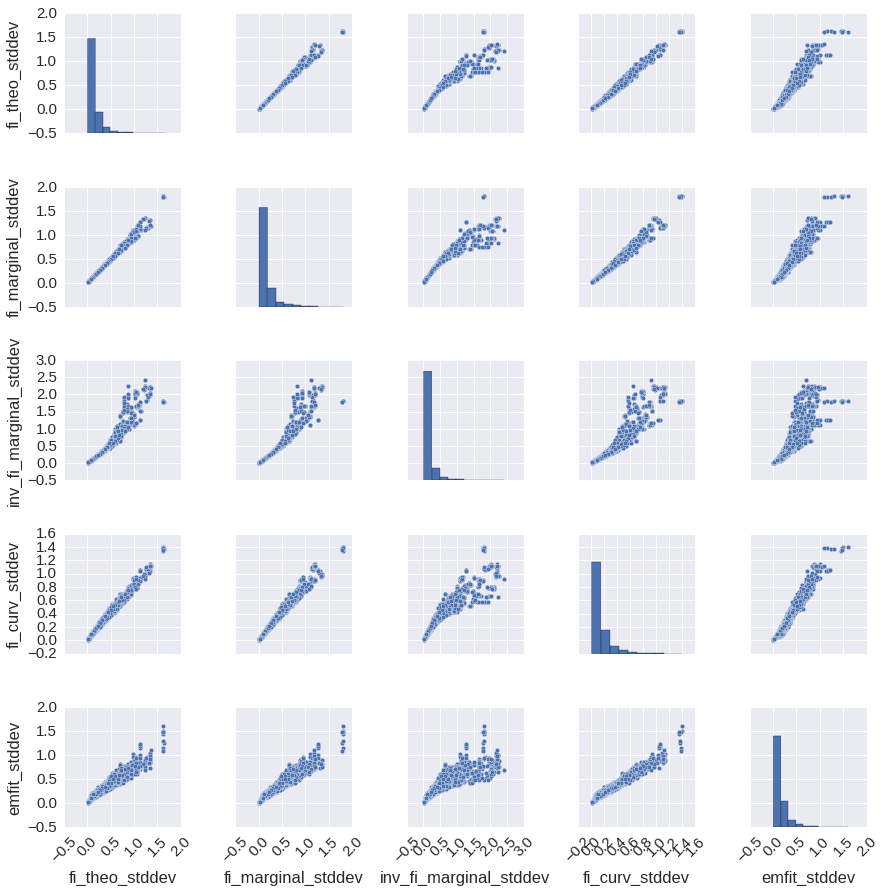

In [75]:
# Cross-correlation plots
g = sns.pairplot(df_fits_filtered,
             vars=['fi_theo_stddev', 'fi_marginal_stddev', 'inv_fi_marginal_stddev', 
                   'fi_curv_stddev', 'emfit_stddev'],
            )
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)


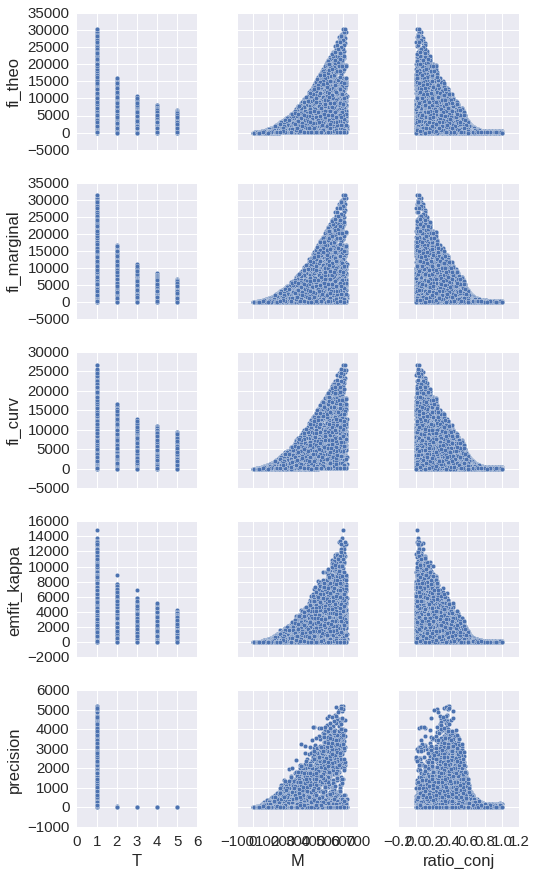

In [76]:
# Check parameters effects
sns.pairplot(df_fits_filtered,
             x_vars=parameter_names_sorted,
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'precision']
            )

In [77]:
# for T, subdf in df_fits_filtered.groupby('T'):
#     g = sns.pairplot(subdf,
#                  x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                  y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                 )
#     g.fig.suptitle("T : %d "% T, fontsize=30)
#     for ax in g.axes.flat:  
#         plt.setp(ax.get_xticklabels(), rotation=45)


# -----   T=1 -----




## Quantize parameters

In [78]:
nQuantiles = 20
parameters = ['M', 'ratio_conj']

df_singleitem = filter_dataframe(df_all_fits, dict(T=1))
df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_singleitem, parameters, nQuantiles)

In [111]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    return utils.plot_mean_std_area(param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel
                                   )

### trying quantized Dataframes

In [79]:
df_conj = filter_quantized_param(df_quantized, 
                                 dict(ratio_conj=0.99), 
                                 param_qbins
                                )

In [80]:
# df_conj = df_quantized[df_quantized.ratio_conj == 1.]

In [81]:
df_conj[['fi_theo', 'emfit_stddev', 'emfit_target', 'M', 'ratio_conj']].corr()

,fi_theo,emfit_stddev,emfit_target,M,ratio_conj
fi_theo,1.000000,-0.624168,0.191123,0.999174,-0.073475
emfit_stddev,-0.624168,1.000000,-0.600509,-0.625273,0.335520
emfit_target,0.191123,-0.600509,1.000000,0.190700,-0.156459
M,0.999174,-0.625273,0.190700,1.000000,-0.106878
ratio_conj,-0.073475,0.335520,-0.156459,-0.106878,1.000000


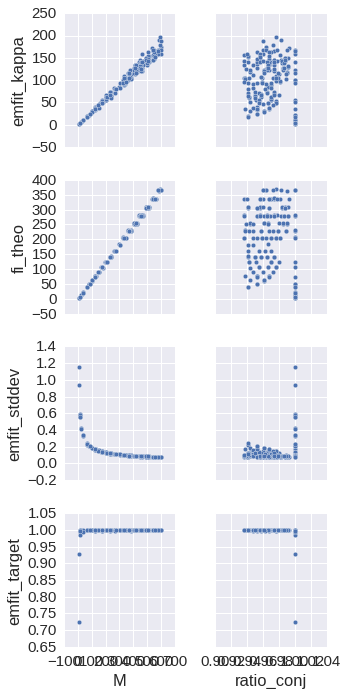

In [82]:
sns.pairplot(df_conj,
             x_vars=['M', 'ratio_conj'],
             y_vars=['emfit_kappa', 'fi_theo', 'emfit_stddev', 'emfit_target']
            )

## Population size effect plot

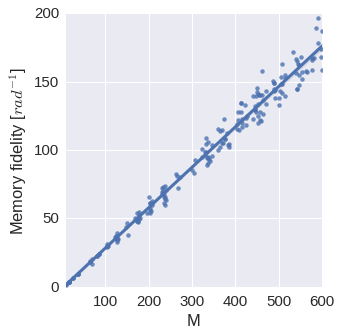

In [134]:

g = sns.lmplot(data=df_conj, x='M', y='emfit_kappa', truncate=True, fit_reg=True)
g.set(xlim=(df_conj.M.min(), df_conj.M.max()),
      ylim=(0, 200)
     )
g.set(xlabel="M", 
      ylabel='Memory fidelity [$rad^{-1}$]'
     )
g.savefig(dataio.create_formatted_filename("M_emfitkappa_linreg_{label}_{unique_id}.pdf"))

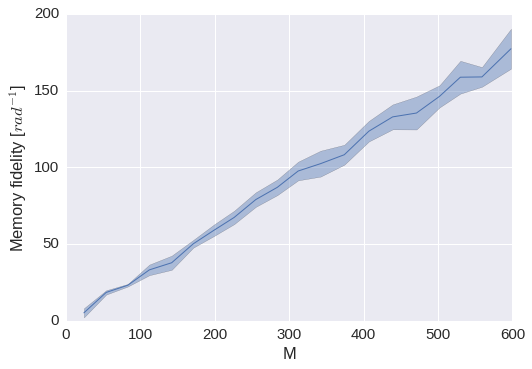

In [132]:
ax = plot_mean_std_df(df_conj, 
                 'M', 
                 'emfit_kappa', 
                 param_qbins_middle, 
                 xlabel='M',
                 ylabel='Memory fidelity [$rad^{-1}$]'
                )

ax.set_xlim((0, 600));
ax.figure.savefig(dataio.create_formatted_filename("M_emfitkappa_area_{label}_{unique_id}.pdf"))

## Create 2d plots M/ratio

In [85]:
# df_Mratio_effect = df_quantized.pivot_table(index='M_qi', columns='ratio_conj_qi', aggfunc='mean')

In [86]:
# cmap = sns.light_palette("green", as_cmap=True)

# ax = sns.heatmap(df_Mratio_effect['emfit_stddev'].T, 
#                  yticklabels=["%.2f" % v for v in param_qbins_middle['ratio_conj']],
#                  xticklabels=["%d" % v for v in param_qbins_middle['M']],
#                  cmap=cmap
#                 )
# ax.invert_yaxis()
# ax.set_ylabel("ratio conj")
# ax.set_xlabel("M")

In [87]:
# target_stddev = utils.kappa_to_stddev(100)
# kappa_evolution = df_Mratio_effect['emfit_stddev']/target_stddev
# kappa_evolution[kappa_evolution < 0.1] = 0.1
# kappa_evolution[kappa_evolution > 5.] = 5.

# cmap = sns.diverging_palette(145, 280, s=85, l=25, n=10, as_cmap=True)
# ax, im = utils.pcolor_2d_data(kappa_evolution, 
#                               x=param_qbins_middle['M'],
#                               y=param_qbins_middle['ratio_conj'], 
#                               xlabel='M', 
#                               xlabel_format="%d",
#                               ylabel='ratio conj', 
#                               vmin=0.5,
#                               vmax=1.5,
#                               cmap=cmap
#                              )
# ax.grid('off')

In [88]:
# fi_kappa_ratio = df_Mratio_effect['fi_theo_stddev']/(df_Mratio_effect['emfit_stddev'])
# fi_kappa_ratio[fi_kappa_ratio > 1.5] = 1.5
# fi_kappa_ratio[fi_kappa_ratio < 0.5] = 0.5

# cmap = sns.diverging_palette(145, 280, s=85, l=25, n=7, as_cmap=True)
# ax, im = utils.pcolor_2d_data(fi_kappa_ratio, 
#                               x=param_qbins_middle['M'],
#                               y=param_qbins_middle['ratio_conj'], 
#                               xlabel='M', 
#                               xlabel_format="%d",
#                               ylabel='ratio conj', 
#                               vmin=0.5,
#                               vmax=1.5,
#                               cmap=cmap
#                              )
# ax.grid('off')

## Interpolate 2D plots instead

In [89]:
def add_target_kappa_columns(df, target_kappa=100):
    target_kappa_ratio = df['emfit_kappa']/target_kappa
    target_kappa_ratio[target_kappa_ratio > 5.] = 5.
    target_kappa_ratio[target_kappa_ratio < 0.01] = 0.01

    target_fi_ratio = df['fi_theo']/(2*target_kappa)
    target_fi_ratio[target_fi_ratio > 5.] = 5.
    target_fi_ratio[target_fi_ratio < 0.01] = 0.01

    df.loc[:, 'target_kappa_ratio'] = target_kappa_ratio
    df.loc[:, 'target_fi_ratio'] = target_fi_ratio

def add_target_stddev_columns(df, target_stddev=0.2):
    target_stddev_ratio = df['emfit_stddev']/target_stddev
    target_stddev_ratio[target_stddev_ratio > 5.] = 5.
    target_stddev_ratio[target_stddev_ratio < 0.01] = 0.01

    target_fi_stddev_ratio = df['fi_theo_stddev']/(target_stddev)
    target_fi_stddev_ratio[target_fi_stddev_ratio > 5.] = 5.
    target_fi_stddev_ratio[target_fi_stddev_ratio < 0.01] = 0.01
    
    target_margfi_stddev_ratio = df['inv_fi_marginal_stddev']/(target_stddev)
    target_margfi_stddev_ratio[target_margfi_stddev_ratio > 5.] = 5.
    target_margfi_stddev_ratio[target_margfi_stddev_ratio < 0.01] = 0.01
    
    df.loc[:, 'target_stddev_ratio'] = target_stddev_ratio
    df.loc[:, 'target_fi_stddev_ratio'] = target_fi_stddev_ratio
    df.loc[:, 'target_margfi_stddev_ratio'] = target_margfi_stddev_ratio

In [90]:
target_kappa = 30
add_target_kappa_columns(df_quantized, target_kappa=target_kappa)
add_target_stddev_columns(df_quantized, target_stddev=utils.kappa_to_stddev(target_kappa))

In [91]:
M_int_space = np.sort(df_quantized['M'].unique())
ratio_int_space = np.sort(df_quantized['ratio_conj'].unique())

In [92]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    return spint.SmoothBivariateSpline(df[x_col], 
                          df[y_col],
                          df[interpolate_column],
                          kx=kx, ky=ky, s=s)

In [93]:
def plot_interpolated_Mratio(df, target_column, 
                             x_col='M', y_col='ratio_conj', 
                             title='', 
                             vmin=1.5, vmax=0.5, 
                             cmap='RdBu_r'):
    x_int_space = M_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col
                                             )
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=11,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

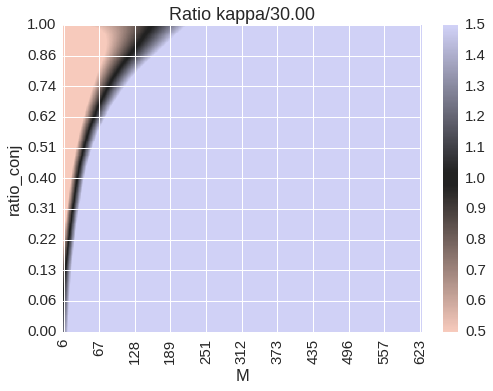

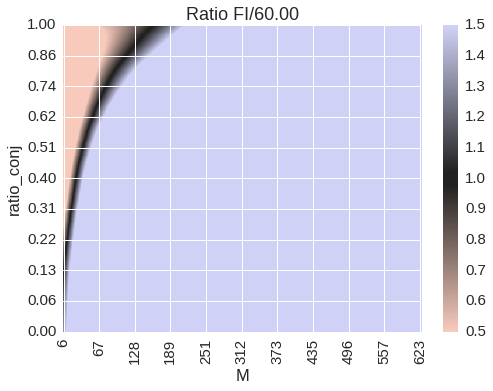

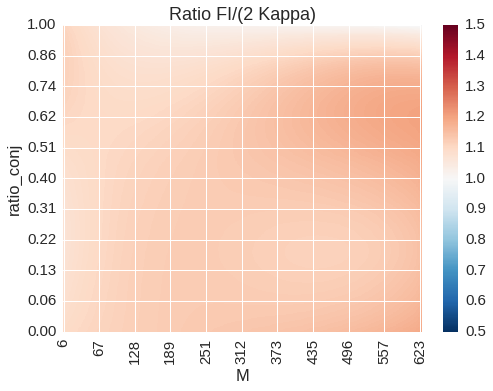

In [94]:
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')
plot_interpolated_Mratio(df_quantized, 'target_kappa_ratio', title='Ratio kappa/%.2f' % (target_kappa), cmap=cmap_div)
plot_interpolated_Mratio(df_quantized, 'target_fi_ratio', title='Ratio FI/%.2f' % (2*target_kappa), cmap=cmap_div)
ax_fikappa_ratio, _ = plot_interpolated_Mratio(df_quantized, 'fi_fidelity_ratio', title='Ratio FI/(2 Kappa)')

In [95]:
ax_fikappa_ratio.figure.savefig(dataio.create_formatted_filename("fikappa_ratio_mixed_040916_{label}_{unique_id}.pdf"))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f06ecdf2bd0>,
 <matplotlib.image.AxesImage at 0x7f06ecd47490>)

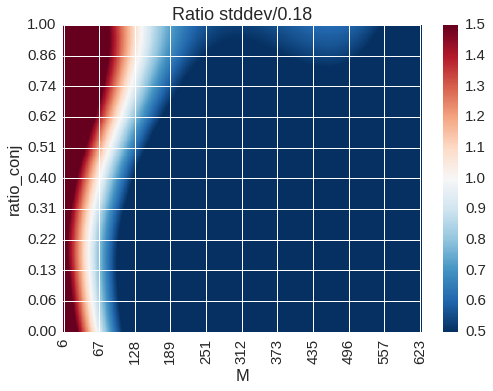

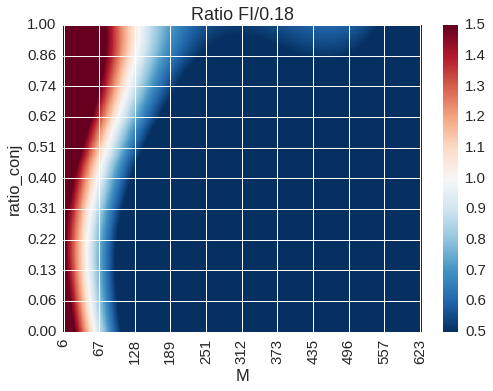

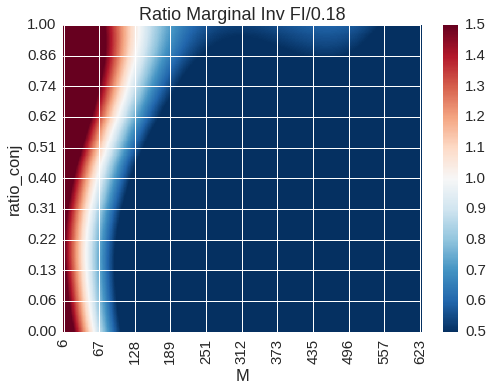

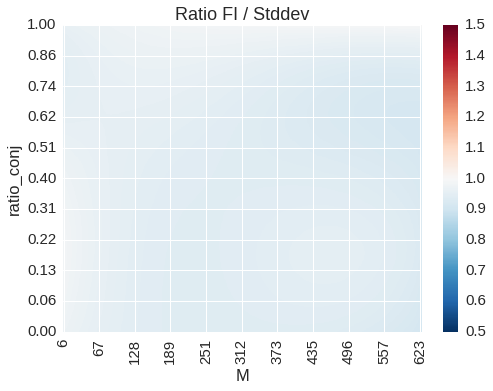

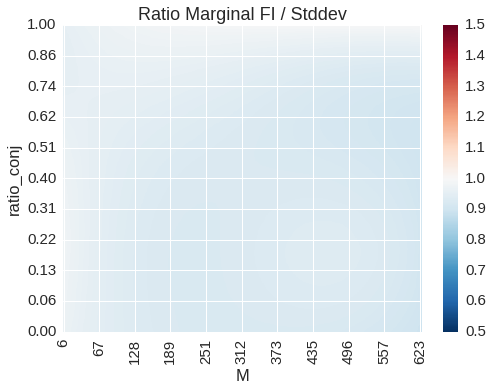

In [96]:
target_stddev = utils.kappa_to_stddev(target_kappa)
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')
plot_interpolated_Mratio(df_quantized, 'target_stddev_ratio', 
                         title='Ratio stddev/%.2f' % (target_stddev), 
                        )
plot_interpolated_Mratio(df_quantized, 'target_fi_stddev_ratio', 
                         title='Ratio FI/%.2f' % (target_stddev), 
                        )
plot_interpolated_Mratio(df_quantized, 'target_margfi_stddev_ratio', 
                         title='Ratio Marginal Inv FI/%.2f' % (target_stddev), 
                        )
plot_interpolated_Mratio(df_quantized, 'fi_stddev_ratio', title='Ratio FI / Stddev')
plot_interpolated_Mratio(df_quantized, 'margfi_stddev_ratio', title='Ratio Marginal FI / Stddev')

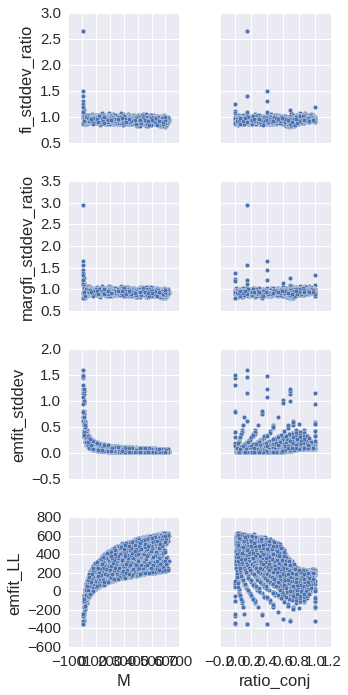

In [97]:
sns.pairplot(df_quantized,
             x_vars=['M', 'ratio_conj'],
             y_vars=['fi_stddev_ratio', 'margfi_stddev_ratio', 'emfit_stddev', 'emfit_LL']
            )

# --------- T = 2  -----------

In [98]:
df_quantized_2, param_qbins, param_qbins_middle = df_add_quantize_parameters(filter_dataframe(df_all_fits, dict(T=2)), 
                                                                           parameters, 
                                                                           nQuantiles)

In [99]:
target_kappa = 10
add_target_kappa_columns(df_quantized_2, target_kappa=target_kappa)
add_target_stddev_columns(df_quantized_2, target_stddev=utils.kappa_to_stddev(target_kappa))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f06ef1b4850>,
 <matplotlib.image.AxesImage at 0x7f06ef528710>)

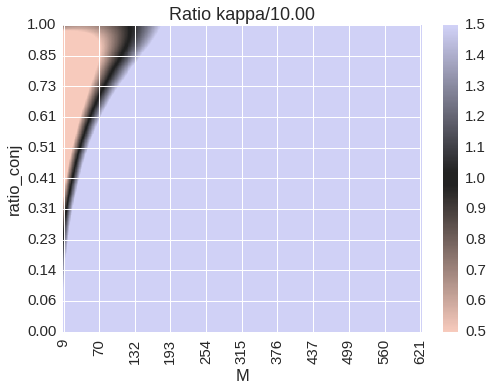

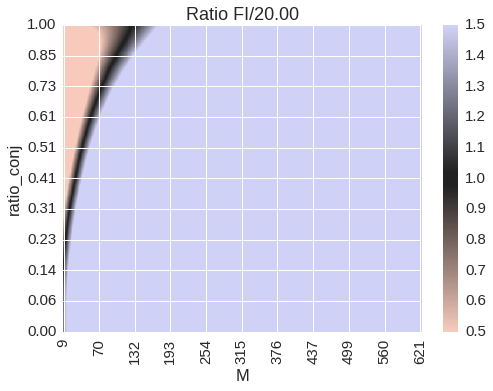

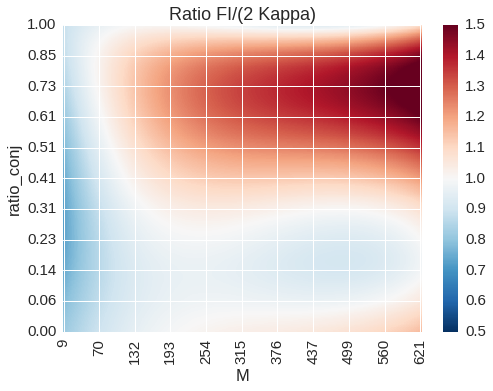

In [100]:
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')
plot_interpolated_Mratio(df_quantized_2, 'target_kappa_ratio', title='Ratio kappa/%.2f' % (target_kappa), cmap=cmap_div)
plot_interpolated_Mratio(df_quantized_2, 'target_fi_ratio', title='Ratio FI/%.2f' % (2*target_kappa), cmap=cmap_div)
plot_interpolated_Mratio(df_quantized_2, 'fi_fidelity_ratio', title='Ratio FI/(2 Kappa)')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f06ed3a8fd0>,
 <matplotlib.image.AxesImage at 0x7f06ed328890>)

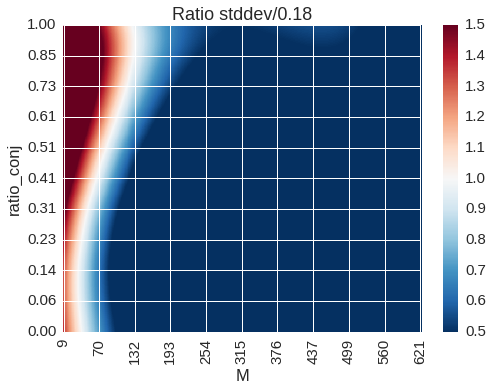

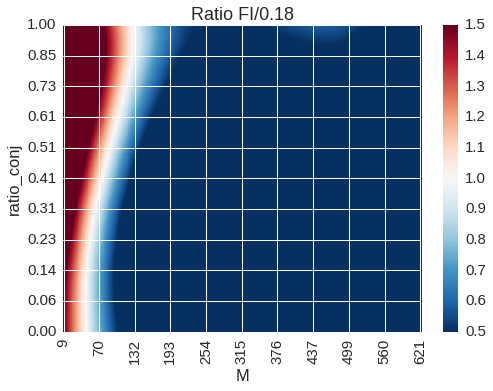

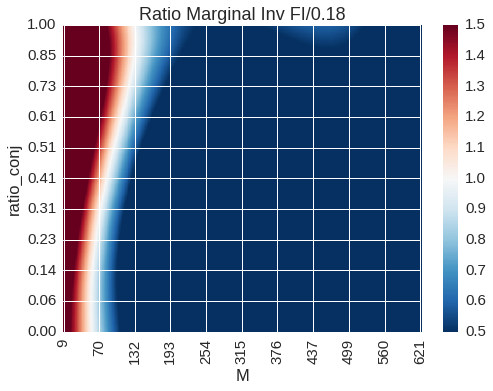

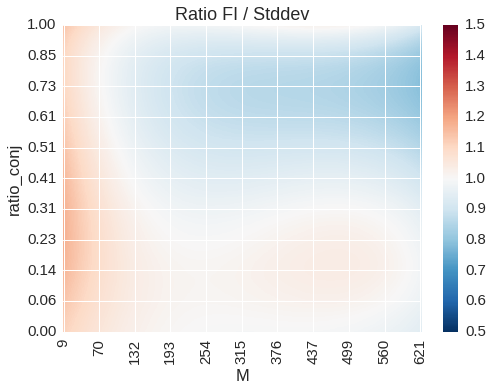

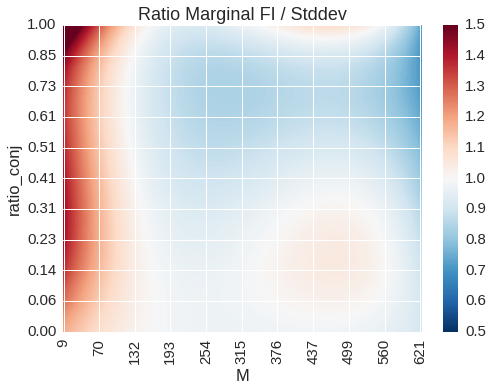

In [101]:
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')
plot_interpolated_Mratio(df_quantized_2, 'target_stddev_ratio', 
                         title='Ratio stddev/%.2f' % (target_stddev), 
                        )
plot_interpolated_Mratio(df_quantized_2, 'target_fi_stddev_ratio', 
                         title='Ratio FI/%.2f' % (target_stddev), 
                        )
plot_interpolated_Mratio(df_quantized_2, 'target_margfi_stddev_ratio', 
                         title='Ratio Marginal Inv FI/%.2f' % (target_stddev), 
                        )
plot_interpolated_Mratio(df_quantized_2, 'fi_stddev_ratio', title='Ratio FI / Stddev')
plot_interpolated_Mratio(df_quantized_2, 'margfi_stddev_ratio', title='Ratio Marginal FI / Stddev')

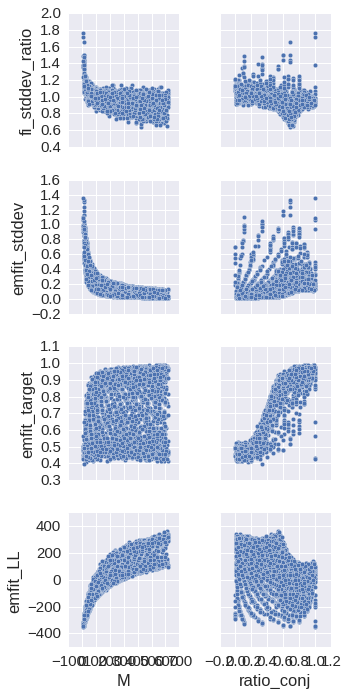

In [102]:
sns.pairplot(df_quantized_2,
             x_vars=['M', 'ratio_conj'],
             y_vars=['fi_stddev_ratio', 'emfit_stddev', 'emfit_target', 'emfit_LL']
            )

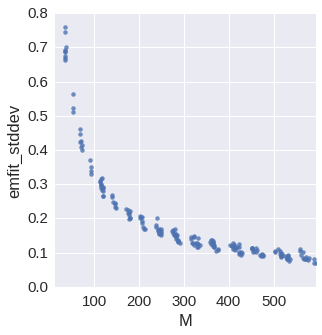

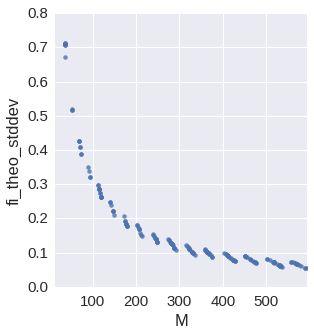

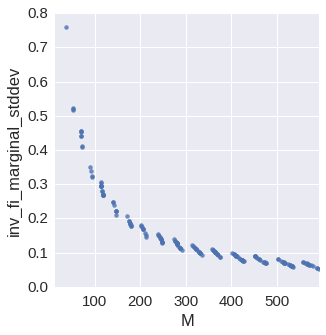

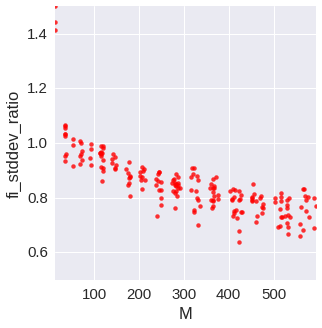

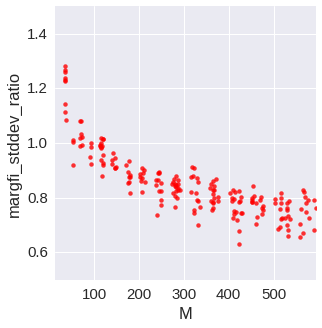

In [103]:
## Ratio Conj 0.7 is weird ?

df_ratioproblem = filter_quantized_param(df_quantized_2, dict(ratio_conj=0.7), param_qbins)

g = sns.lmplot(data=df_ratioproblem, x='M', y='emfit_stddev', truncate=True, order=2, fit_reg=False)
xlims = (df_ratioproblem['M'].min(), df_ratioproblem['M'].max())
g.set(xlim=xlims, ylim=(0, 0.8))

g = sns.lmplot(data=df_ratioproblem, x='M', y='fi_theo_stddev', truncate=True, order=2, fit_reg=False)
g.set(xlim=xlims, ylim=(0, 0.8))

g = sns.lmplot(data=df_ratioproblem, x='M', y='inv_fi_marginal_stddev', truncate=True, order=2, fit_reg=False)
g.set(xlim=xlims, ylim=(0, 0.8))


g = sns.lmplot(data=df_ratioproblem, x='M', y='fi_stddev_ratio', truncate=True, order=2, fit_reg=False,
               scatter_kws={'color': 'red'}
              )
g.set(xlim=xlims, ylim=(0.5, 1.5))

g = sns.lmplot(data=df_ratioproblem, x='M', y='margfi_stddev_ratio', truncate=True, order=2, fit_reg=False,
               scatter_kws={'color': 'red'}
              )
g.set(xlim=xlims, ylim=(0.5, 1.5))

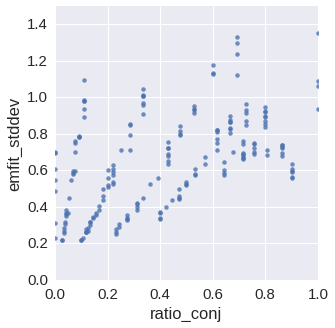

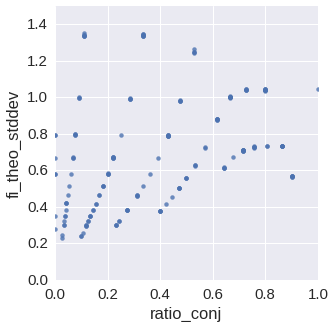

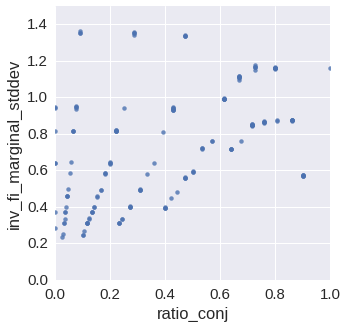

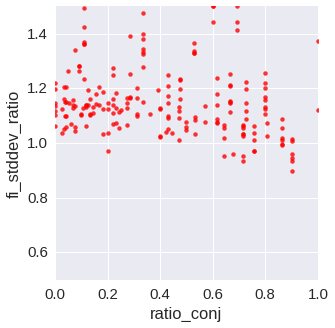

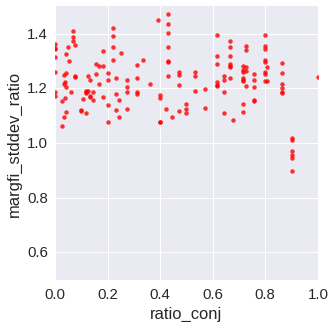

In [104]:
## Check Small M effect

df_smallM = filter_quantized_param(df_quantized_2, dict(M=10), param_qbins)

g = sns.lmplot(data=df_smallM, x='ratio_conj', y='emfit_stddev', order=2, fit_reg=False)
xlims = (df_smallM['ratio_conj'].min(), df_smallM['ratio_conj'].max())
g.set(xlim=xlims, ylim=(0, 1.5))

g = sns.lmplot(data=df_smallM, x='ratio_conj', y='fi_theo_stddev', order=2, fit_reg=False)
g.set(xlim=xlims, ylim=(0, 1.5))

g = sns.lmplot(data=df_smallM, x='ratio_conj', y='inv_fi_marginal_stddev', order=2, fit_reg=False)
g.set(xlim=xlims, ylim=(0, 1.5))

g = sns.lmplot(data=df_smallM, x='ratio_conj', y='fi_stddev_ratio', order=2, fit_reg=False,
               scatter_kws={'color': 'red'}
              )
g.set(xlim=xlims, ylim=(0.5, 1.5))

g = sns.lmplot(data=df_smallM, x='ratio_conj', y='margfi_stddev_ratio', truncate=True, order=2, fit_reg=False,
               scatter_kws={'color': 'red'}
              )
g.set(xlim=xlims, ylim=(0.5, 1.5))

### Population size effect

In [105]:
df_conj_2 = filter_quantized_param(df_quantized_2, 
                                 dict(ratio_conj=0.99), 
                                 param_qbins
                                )

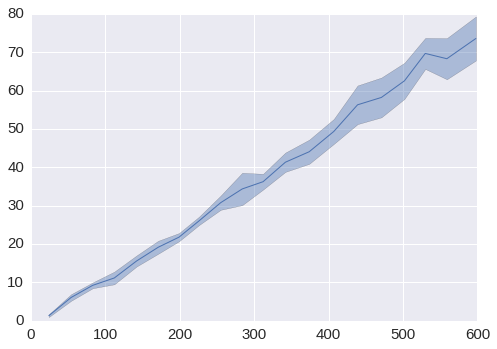

In [110]:
plot_mean_std_df(df_conj_2, 'M', 'emfit_kappa', param_qbins_middle)